# Лабораторная работа 5

Датасет - **Объекты вокруг Земли**	https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects

1. **name**: Название астероида
2. **absolute_magnitude**: Абсолютная звездная величина астероида
3. **estimated_diameter_min**: Минимальный оценочный диаметр астероида (в километрах)
4. **estimated_diameter_max**: Максимальный оценочный диаметр астероида (в километрах)
5. **hazardous**: Является ли астероид потенциально опасным
6. **relative_velocity**: Относительная скорость астероида по отношению к Земле (в километрах в секунду)
7. **miss_distance**: Расстояние между Землёй и астероидом в момент его максимального сближения
8. **orbiting_body**: Центральное небесное тело, вокруг которого движется астероид
9. **sentry_object**: Указывает, отслеживается ли данный объект системой мониторинга NASA Sentry
10. **z**: Глубина бриллианта в миллиметрах

**Бизнес-цели**: 
1. Поддержка образовательных и информационных программ.
2. Группировать астероиды по "интересным" характеристикам для визуализации и информирования общества (например, медленные и большие астероиды, самые близкие к Земле и т.д.).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv("data/neo.csv")
df = df.head(1500)
df.head()

id                 name  est_diameter_min  est_diameter_max  \
0  2162635  162635 (2000 SS164)          1.198271          2.679415   
1  2277475    277475 (2005 WK4)          0.265800          0.594347   
2  2512244   512244 (2015 YE18)          0.722030          1.614507   
3  3596030          (2012 BV13)          0.096506          0.215794   
4  3667127          (2014 GE35)          0.255009          0.570217   

   relative_velocity  miss_distance orbiting_body  sentry_object  \
0       13569.249224   5.483974e+07         Earth          False   
1       73588.726663   6.143813e+07         Earth          False   
2      114258.692129   4.979872e+07         Earth          False   
3       24764.303138   2.543497e+07         Earth          False   
4       42737.733765   4.627557e+07         Earth          False   

   absolute_magnitude  hazardous  
0               16.73      False  
1               20.00       True  
2               17.83      False  
3               22.20      False  
4               20.09       True

#### Очистка данных

Удалим несущественные данные

In [2]:
df_cleaned = df.drop(columns=['name', 'orbiting_body', 'sentry_object', 'hazardous'], errors='ignore').dropna()
df_cleaned.head()

id  est_diameter_min  est_diameter_max  relative_velocity  \
0  2162635          1.198271          2.679415       13569.249224   
1  2277475          0.265800          0.594347       73588.726663   
2  2512244          0.722030          1.614507      114258.692129   
3  3596030          0.096506          0.215794       24764.303138   
4  3667127          0.255009          0.570217       42737.733765   

   miss_distance  absolute_magnitude  
0   5.483974e+07               16.73  
1   6.143813e+07               20.00  
2   4.979872e+07               17.83  
3   2.543497e+07               22.20  
4   4.627557e+07               20.09

#### Визуализация парных взаимосвязей

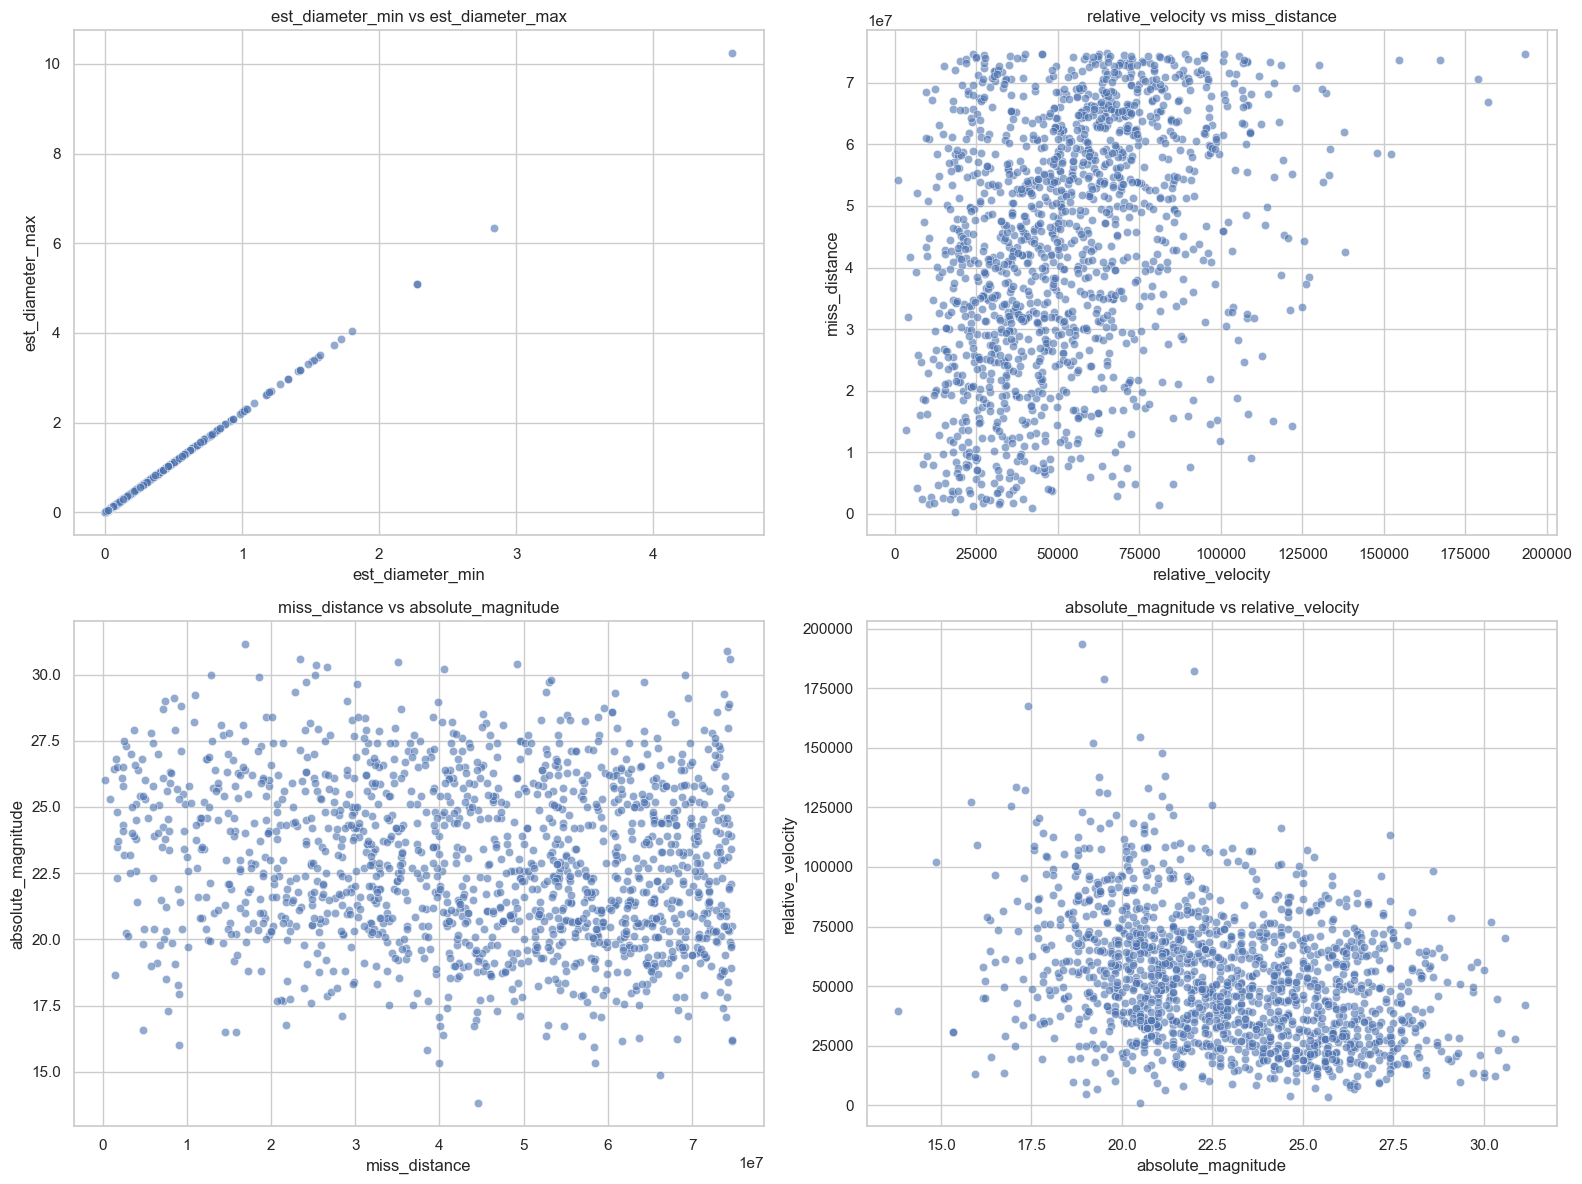

In [3]:
sns.set(style="whitegrid")

# связь между минимальным и максимальным диаметром астероидов
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
sns.scatterplot(x=df_cleaned['est_diameter_min'], y=df_cleaned['est_diameter_max'], alpha=0.6)
plt.title('est_diameter_min vs est_diameter_max')

# связь между расстоянием промаха и яркостью астероида
plt.subplot(2, 2, 2)
sns.scatterplot(x=df_cleaned['relative_velocity'], y=df_cleaned['miss_distance'], alpha=0.6)
plt.title('relative_velocity vs miss_distance')

# связь между расстоянием промаха и абсолютной звездной величиной
plt.subplot(2, 2, 3)
sns.scatterplot(x=df_cleaned['miss_distance'], y=df_cleaned['absolute_magnitude'], alpha=0.6)
plt.title('miss_distance vs absolute_magnitude')

# связь яркости с его относительной скоростью
plt.subplot(2, 2, 4)
sns.scatterplot(x=df_cleaned['absolute_magnitude'], y=df_cleaned['relative_velocity'], alpha=0.6)
plt.title('absolute_magnitude vs relative_velocity')

plt.tight_layout()
plt.show()

#### Стандартизация данных для кластеризации

Стандартизация данных — процесс приведения всех признаков (столбцов) к одному масштабу.

In [4]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cleaned)
data_scaled

array([[-0.51120494,  3.73744939,  3.73744939, -1.45805986,  0.5311181 ,
        -2.02560332],
       [-0.50518329,  0.35347528,  0.35347528,  0.77156175,  0.86292579,
        -0.94818185],
       [-0.49287316,  2.00915073,  2.00915073,  2.28238187,  0.27762431,
        -1.66316796],
       ...,
       [-0.42311599, -0.5744506 , -0.5744506 , -0.12789786,  0.31239586,
         1.39117363],
       [-0.42119188, -0.52315117, -0.52315117, -0.94732109,  1.179388  ,
         0.76514892],
       [-0.51510459,  3.1416016 ,  3.1416016 , -0.61031165, -0.21666262,
        -1.92016758]])

#### Агломеративная (иерархическая) кластеризация

Иерархическая кластеризация — метод машинного обучения, предназначенный для группировки объектов (точек данных) на основе их схожести или расстояния друг от друга. Основная идея заключается в создании структуры кластеров в виде дерева (дендрограммы), которое показывает, как объекты группируются на разных уровнях.

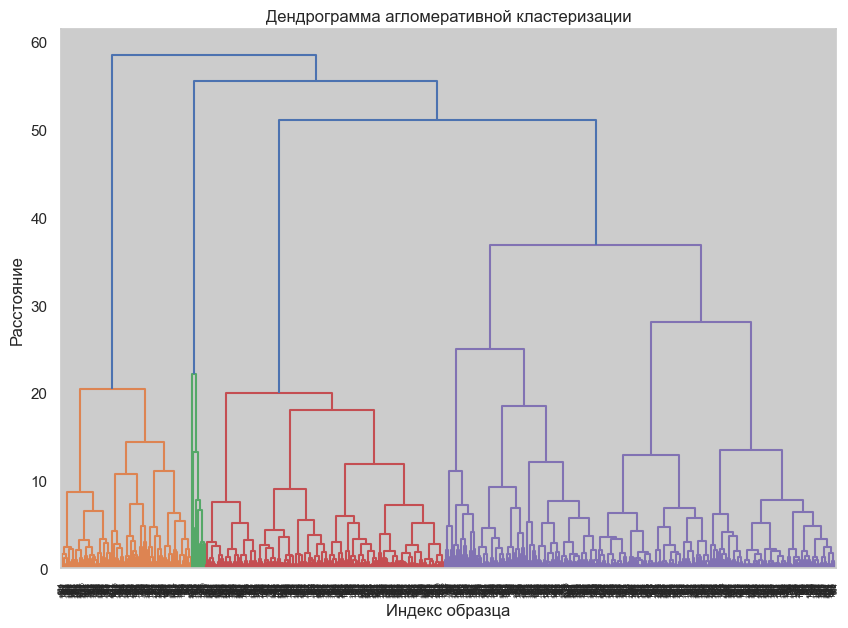

[ 7 17 13 ... 18  9  7]


In [5]:
linkage_matrix = linkage(data_scaled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Дендрограмма агломеративной кластеризации')
plt.xlabel('Индекс образца')
plt.ylabel('Расстояние')
plt.show()

result = fcluster(linkage_matrix, t=10, criterion='distance')
print(result) 

#### Визуализация распределения кластеров

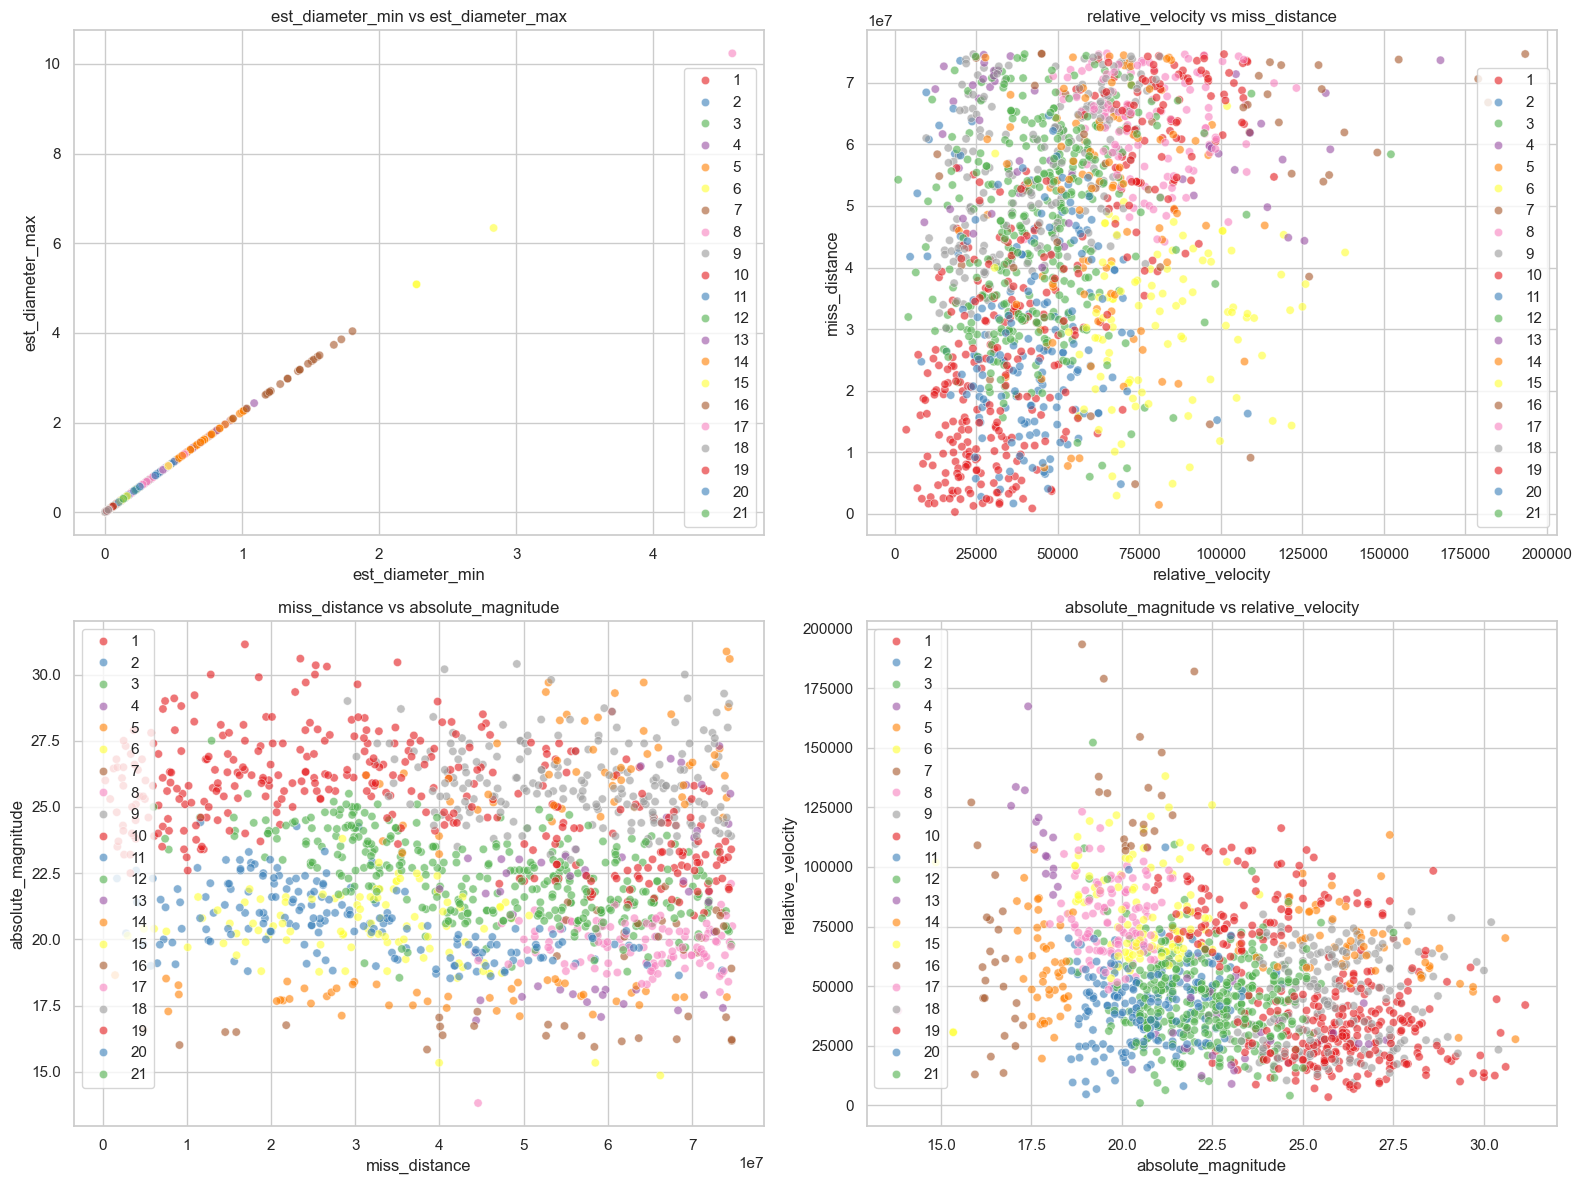

In [6]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
sns.scatterplot(x=df_cleaned['est_diameter_min'], y=df_cleaned['est_diameter_max'], hue=result, palette='Set1', alpha=0.6)
plt.title('est_diameter_min vs est_diameter_max')

plt.subplot(2, 2, 2)
sns.scatterplot(x=df_cleaned['relative_velocity'], y=df_cleaned['miss_distance'], hue=result, palette='Set1', alpha=0.6)
plt.title('relative_velocity vs miss_distance')

plt.subplot(2, 2, 3)
sns.scatterplot(x=df_cleaned['miss_distance'], y=df_cleaned['absolute_magnitude'], hue=result, palette='Set1', alpha=0.6)
plt.title('miss_distance vs absolute_magnitude')

plt.subplot(2, 2, 4)
sns.scatterplot(x=df_cleaned['absolute_magnitude'], y=df_cleaned['relative_velocity'], hue=result, palette='Set1', alpha=0.6)
plt.title('absolute_magnitude vs relative_velocity')

plt.tight_layout()
plt.show()

#### KMeans (неиерархическая кластеризация) для сравнения

Неиерархическая кластеризация — метод группировки данных, при котором объекты распределяются по заданному числу кластеров(в нашем случае - 
𝑘 в методе K-Means), основываясь на определенных метриках расстояния или схожести. В отличие от иерархической кластеризации, которая создает древовидную структуру кластеров, неиерархическая работает с фиксированным количеством кластеров и напрямую распределяет объекты в группы.

K-Means:
* Делит данные на 𝑘 кластеров, **минимизируя сумму квадратов расстояний от каждой точки до её центроида**.
* Центроиды обновляются итеративно, пока результат не стабилизируется.

Центры кластеров:
 [[-0.43863035  0.09971675  0.09971675  0.63756469  0.62405041 -0.45475412]
 [-0.4426337  -0.35846552 -0.35846552 -0.63523481 -0.61852806  0.41688706]
 [ 2.21402038 -0.38941373 -0.38941373 -0.16164814 -0.0129622   0.65296724]
 [-0.50737813  3.15522336  3.15522336  0.6094733   0.11681301 -1.85373482]]


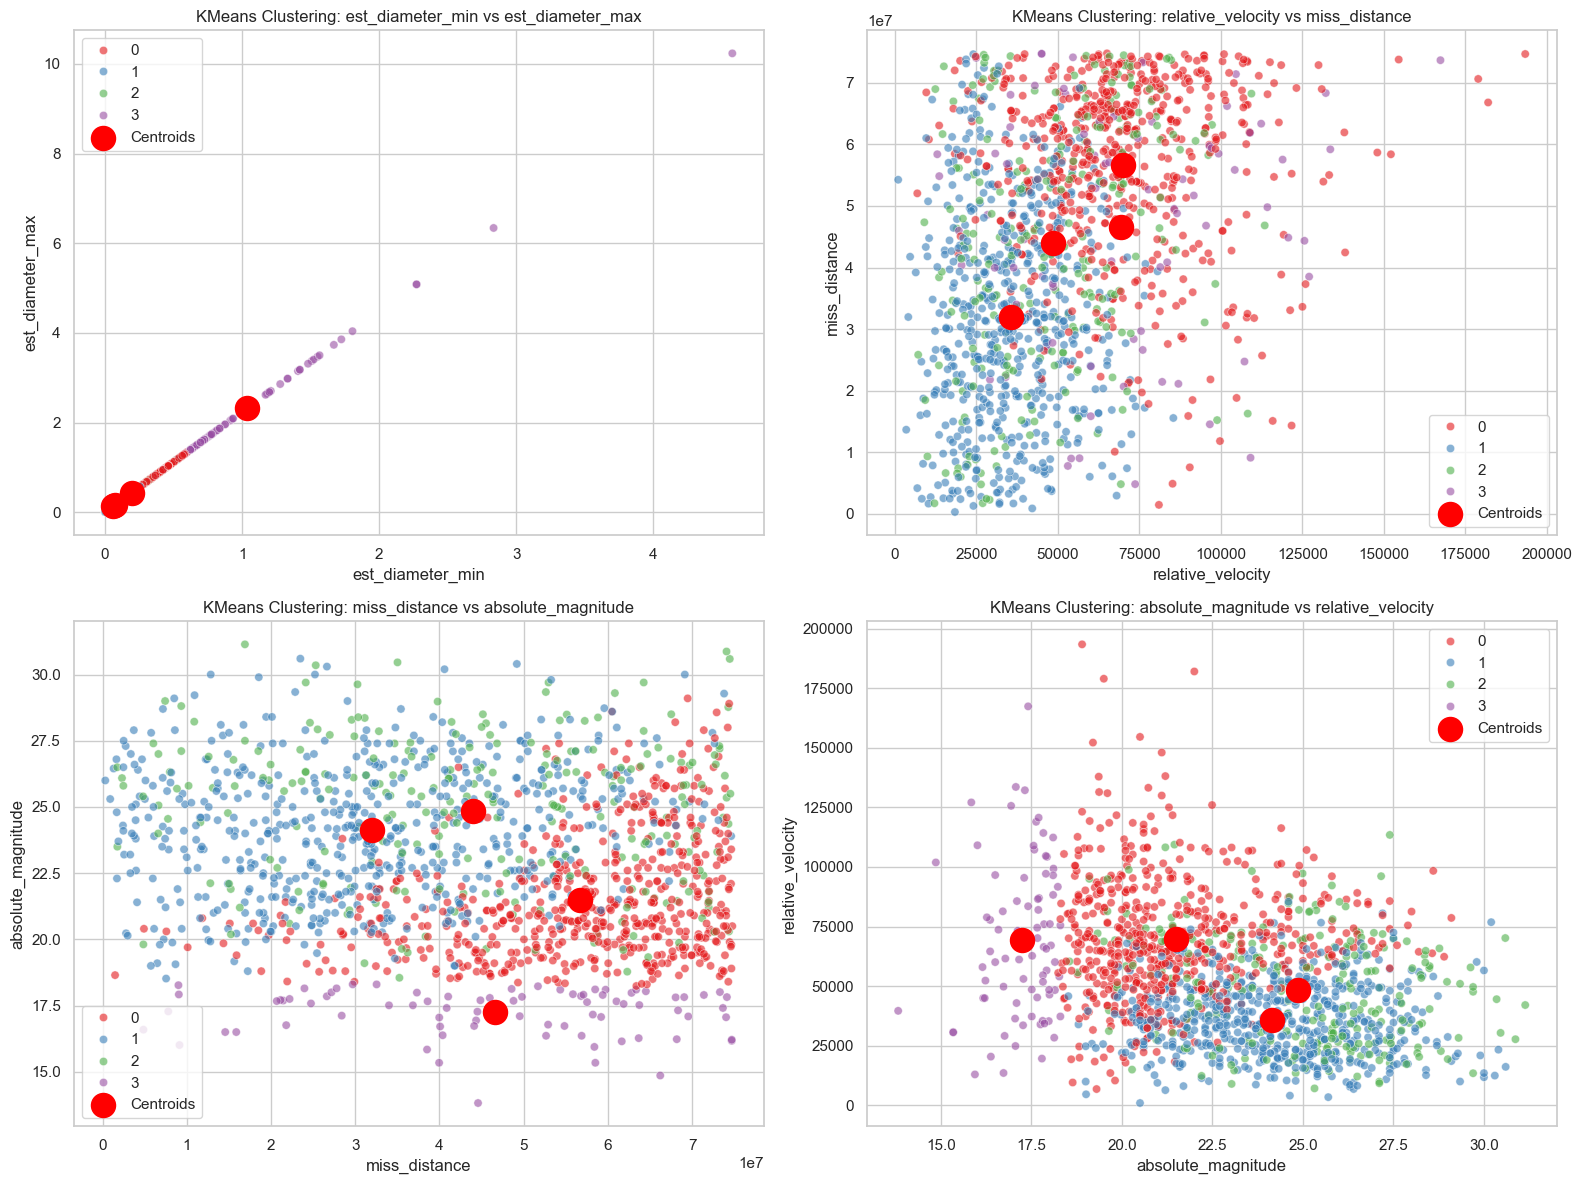

In [7]:
random_state = 17
kmeans = KMeans(n_clusters=4, random_state=random_state)

labels = kmeans.fit_predict(data_scaled)

centers = kmeans.cluster_centers_

print("Центры кластеров:\n", centers)
centers = scaler.inverse_transform(centers)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
sns.scatterplot(x=df_cleaned['est_diameter_min'], y=df_cleaned['est_diameter_max'], hue=labels, palette='Set1', alpha=0.6)
plt.scatter(centers[:, 1], centers[:, 2], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: est_diameter_min vs est_diameter_max')
plt.legend()

plt.subplot(2, 2, 2)
sns.scatterplot(x=df_cleaned['relative_velocity'], y=df_cleaned['miss_distance'], hue=labels, palette='Set1', alpha=0.6)
plt.scatter(centers[:, 3], centers[:, 4], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: relative_velocity vs miss_distance')
plt.legend()

plt.subplot(2, 2, 3)
sns.scatterplot(x=df_cleaned['miss_distance'], y=df_cleaned['absolute_magnitude'], hue=labels, palette='Set1', alpha=0.6)
plt.scatter(centers[:, 4], centers[:, 5], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: miss_distance vs absolute_magnitude')
plt.legend()

plt.subplot(2, 2, 4)
sns.scatterplot(x=df_cleaned['absolute_magnitude'], y=df_cleaned['relative_velocity'], hue=labels, palette='Set1', alpha=0.6)
plt.scatter(centers[:, 5], centers[:, 3], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: absolute_magnitude vs relative_velocity')
plt.legend()

plt.tight_layout()
plt.show()

#### PCA для визуализации сокращенной размерности

PCA (Principal Component Analysis) — метод сокращения размерности, используемый для преобразования высокоразмерных данных в пространство с меньшим количеством измерений, сохраняя при этом как можно больше информации (дисперсии) из исходных данных.

В контексте графиков для визуализации результатов кластеризации, PCA используется для проекции многомерных данных в двумерное пространство, чтобы можно было легко визуализировать кластеры.

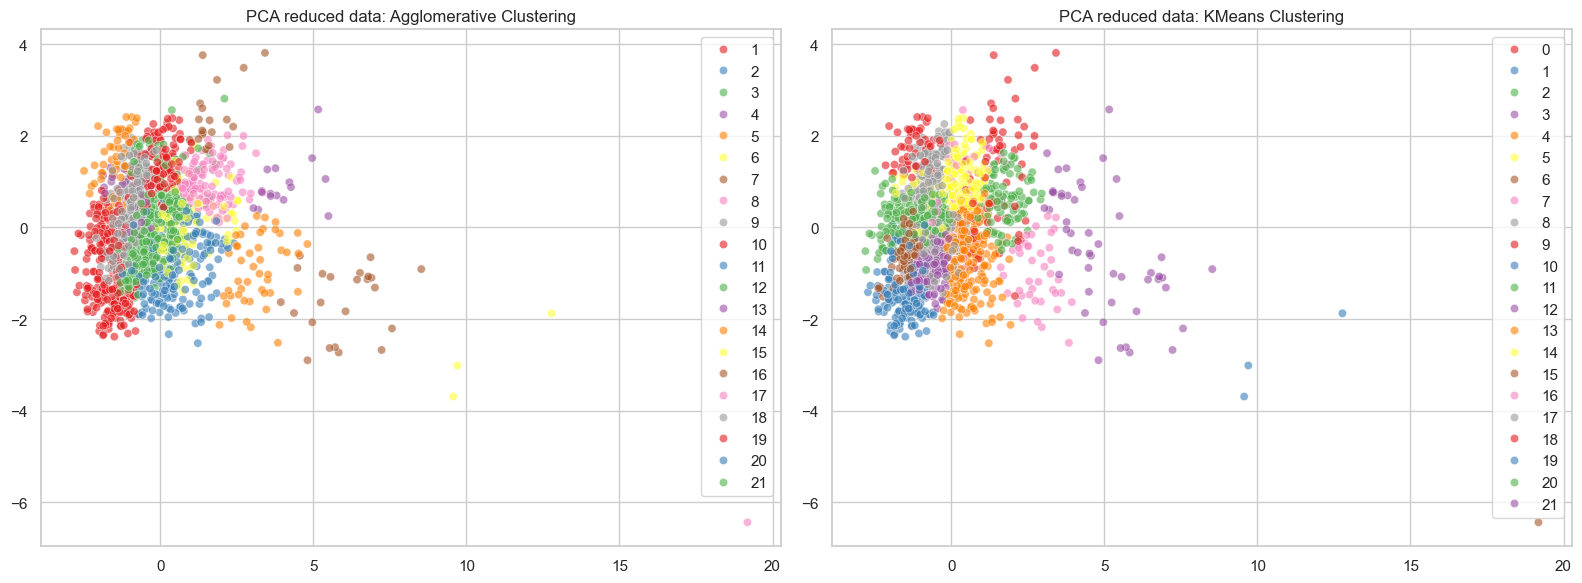

In [13]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=result, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: Agglomerative Clustering')

plt.subplot(1, 2, 2)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: KMeans Clustering')

plt.tight_layout()
plt.show()

#### Анализ инерции для метода локтя (метод оценки суммы квадратов расстояний)

Анализ инерции для метода локтя — это техника, используемая для определения оптимального числа кластеров в задаче кластеризации (например, для алгоритма K-Means). **Метод основывается на оценке суммы квадратичных отклонений (или инерции) объектов от центров их кластеров**.

Инерция (в контексте кластеризации) — это метрика, которая измеряет "плотность" кластеров, то есть, насколько близко точки внутри каждого кластера расположены к его центроиду.
Формально инерция определяется как **сумма квадратов расстояний всех точек до ближайшего центра кластера**.

Метод локтя:
1. Для различных значений 𝑘 (количества кластеров) вычисляется инерция.
2. Значения инерции отображаются на графике в зависимости от 𝑘.
3. Смотрится точка, после которой уменьшение инерции значительно замедляется. Эта точка называется локтем, и соответствующее значение 𝑘 считается оптимальным числом кластеров.

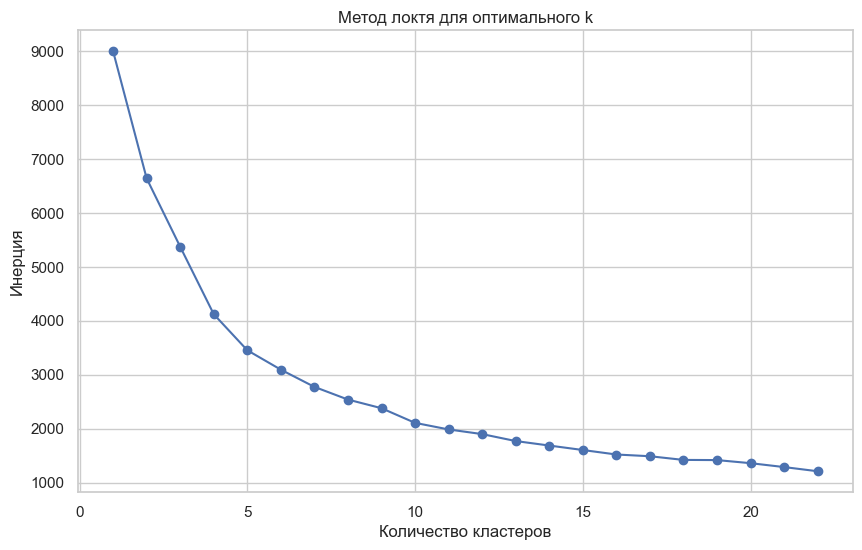

In [9]:
inertias = []
clusters_range = range(1, 23)
for i in clusters_range:
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertias, marker='o')
plt.title('Метод локтя для оптимального k')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

Расчитаем коэффициенты силуэта

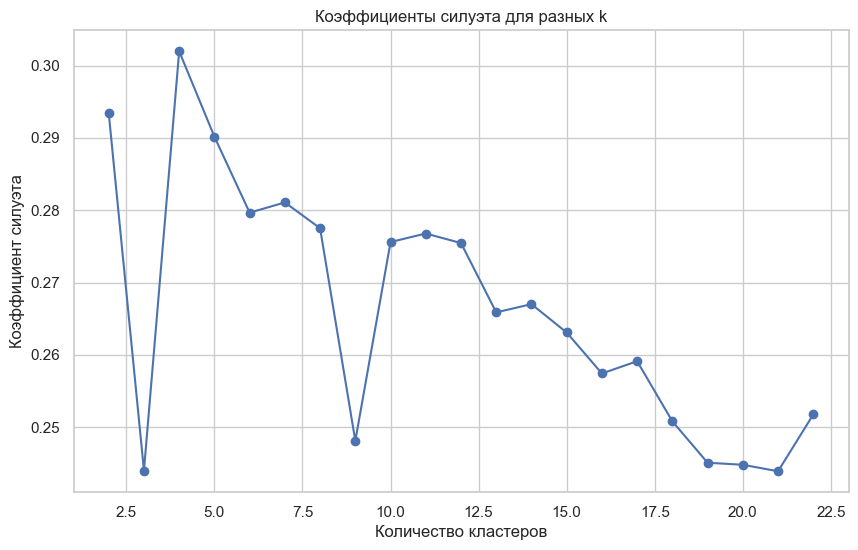

In [10]:
silhouette_scores = []
for i in clusters_range[1:]:  
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(clusters_range[1:], silhouette_scores, marker='o')
plt.title('Коэффициенты силуэта для разных k')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

Средний коэффициент силуэта (silhouette score) используется для оценки качества кластеризации. Его значение лежит в диапазоне от -1 до 1. Что означают различные значения:

* Близко к 1.0 (0.7–1.0): Кластеры хорошо разделены и компактны. Это отличный результат кластеризации.

* От 0.5 до 0.7: Кластеры четко различимы, но есть некоторое пересечение между ними. Это хороший результат.
* От 0.25 до 0.5: Кластеры перекрываются, что указывает на менее четкую границу между группами. Качество кластеризации удовлетворительное, но может потребоваться уточнение числа кластеров или доработка данных.

* Близко к 0.0: Кластеры сильно перекрываются или распределение данных не позволяет выделить четкие группы. В этом случае нужно пересмотреть выбор числа кластеров, алгоритм или исходные данные.

* Меньше 0.0: Плохая кластеризация: точки ближе к центрам чужих кластеров, чем к своим. Это сигнал о том, что данные плохо структурированы для текущей кластеризации.

Средний коэффициент силуэта: 0.302


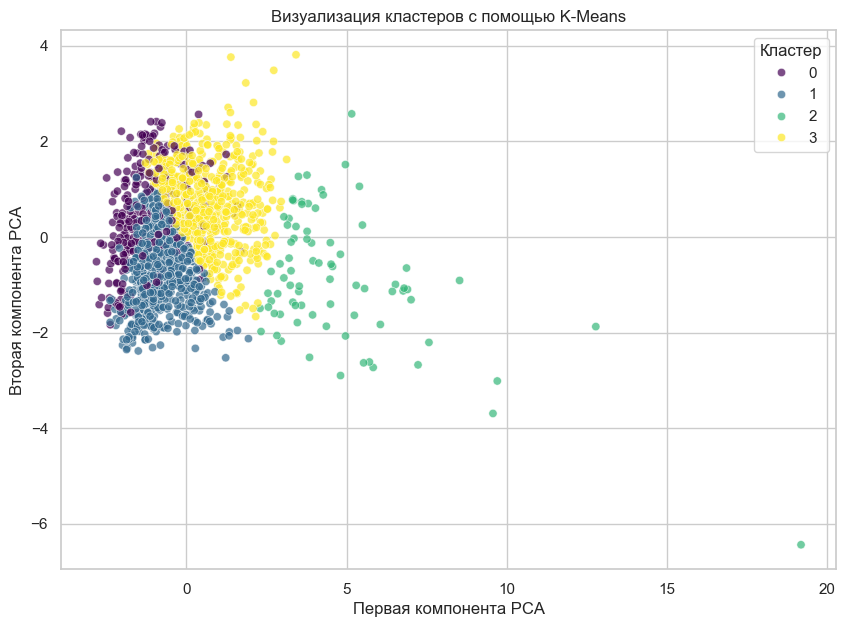

In [11]:
kmeans = KMeans(n_clusters=4, random_state=42)  
df_clusters = kmeans.fit_predict(data_scaled)

silhouette_avg = silhouette_score(data_scaled, df_clusters)
print(f'Средний коэффициент силуэта: {silhouette_avg:.3f}')

pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_clusters, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью K-Means')
plt.xlabel('Первая компонентa PCA')
plt.ylabel('Вторая компонентa PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()

В нашем случае результат находится ближе к хорошему, но пока что всё-таки больше в удовлетворительном состоянии, что приемлемо и говорит о некотором пересечении между кластерами